Layers A and B have the thicknesses  $d_A = 200 nm$  and  $d_B = 300 nm$ , and the dielectric constants $ϵ_A = 12$ and $ϵ_B = 3$.Compute and plot the single-frequency electric field distribution for structure of 10 repeated AB followed by 10 repeated BA.(300 < ω < 600 THz)

### 參數設定

In [1]:
import numpy as np
#頻率相關參數
f = 1.2
omega = 2 * np.pi * f

In [2]:
#結構重複次數
num_pairs = 10
#晶體厚度
d_single = [0.2, 0.3]
d_list = []
for i in range(num_pairs):
    for j in range(len(d_single)-1):
        d_list.append(d_single[0])
        d_list.append(d_single[1])
for i in range(num_pairs):
    for j in range(len(d_single)-1):
        d_list.append(d_single[1])
        d_list.append(d_single[0])
d = sum(d_list)
d_pair = sum(d_single)
#材料介電常數
epsi_single = [12, 3]
epsi_list = []
for i in range(num_pairs):
    for j in range(len(epsi_single)-1):
        epsi_list.append(epsi_single[0])
        epsi_list.append(epsi_single[1])
for i in range(num_pairs):
    for j in range(len(epsi_single)-1):
        epsi_list.append(epsi_single[1])
        epsi_list.append(epsi_single[0])

In [3]:
#材料相位差
delta_list = []
for epsi, a in zip(epsi_list, d_list):
    delta = 2 * omega * a * np.sqrt(epsi)
    delta_list.append(delta)
delta_array = np.array(delta_list)

In [4]:
epsi_all = epsi_list.copy()  
epsi_all.insert(0, 1)
epsi_all.append(1)

### 轉移矩陣數值分析

In [5]:
#介面反射係數
r_list = []
for i in range(len(epsi_all)-1):
    r = (np.sqrt(epsi_all[i]) - np.sqrt(epsi_all[i+1])) / \
        (np.sqrt(epsi_all[i]) + np.sqrt(epsi_all[i+1]))
    r_list.append(r)
r_array = np.array(r_list)
#介面透射係數
t_list = []
for i in range(len(epsi_all)-1):
    t = 2 * (np.sqrt(epsi_all[i])) / \
        (np.sqrt(epsi_all[i]) + np.sqrt(epsi_all[i+1]))
    t_list.append(t)
t_array = np.array(t_list)

In [6]:
#介面反透射矩陣
i = 1j
D_list = []
for idx, t in enumerate(t_array):
    r_num = r_array[idx]
    D = (1 / t) * np.array([[1, r_num],
                            [r_num, 1]])
    D_list.append(D)
D_array = np.array(D_list)

In [7]:
#材料傳遞矩陣
P_list = []
for deltas in delta_array:
    P_11 = np.exp(-i * deltas * 0.5)
    P_22 = np.exp(i * deltas * 0.5)
    P = np.array([[P_11, 0],
                  [0, P_22]])
    P_list.append(P)
P_array = np.array(P_list)

In [8]:
#轉換矩陣
M_temp = np.eye(2, 2)
for k in range(len(epsi_list)):
    M_temp = M_temp @ np.array(D_array[k])
    M_temp = M_temp @ np.array(P_array[k])
M = M_temp @ np.array(D_array[-1])

In [9]:
#反射與透射
Er = M[1,0] / M[0,0]
R_tmat = np.abs(Er**2)
T_tmat = 1 - R_tmat
print(T_tmat)

2.7562475635178885e-09


### 散射矩陣數值分析

In [10]:
detM = M[0,0]*M[1,1] - M[0,1]*M[1,0]
S11 = -M[1,0] / M[1,1]
S21 = detM / M[1,1]
R_smat = np.abs(S11)**2
T_smat = np.abs(S21)**2
print(T_smat)

2.7562473732655647e-09


### meep模擬

In [11]:
import meep as mp
#模擬空間參數
resolution = 500
dpml = 1.0
sz = (d_pair * 30.0) + (dpml * 2.0)
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]
dimensions = 1

In [12]:
#電磁波源(平面波)
sour_z = - (d / 2) - 0.3 
sources = [mp.Source(src=mp.ContinuousSource(frequency=f),
                     component=mp.Ex,
                     center=mp.Vector3(z=sour_z))
          ]

In [13]:
#整體模擬流程(真空場)
sim_vac = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        resolution=resolution)
#數據偵測(真空場)
tran_z = (d / 2) + 0.3
tran_vac_fr = mp.FluxRegion(center=mp.Vector3(z = tran_z))
tran_vac = sim_vac.add_flux(f, 0, 1, tran_vac_fr)
#數據模擬(真空場)  
sim_vac.run(until=20000)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000439882 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 17 with resolution 500
time for set_epsilon = 0.00186396 s
-----------


FloatProgress(value=0.0, description='0% done ', max=20000.0)

Meep progress: 146.933/20000.0 = 0.7% done in 4.0s, 540.5s to go
on time step 147186 (time=147.186), 2.71766e-05 s/step
Meep progress: 333.048/20000.0 = 1.7% done in 8.0s, 472.4s to go
on time step 333595 (time=333.595), 2.14582e-05 s/step
Meep progress: 577.237/20000.0 = 2.9% done in 12.0s, 403.8s to go
on time step 577570 (time=577.57), 1.63952e-05 s/step
Meep progress: 818.304/20000.0 = 4.1% done in 16.0s, 375.1s to go
on time step 819061 (time=819.061), 1.65638e-05 s/step
Meep progress: 1062.084/20000.0 = 5.3% done in 20.0s, 356.6s to go
on time step 1062943 (time=1062.94), 1.64014e-05 s/step
Meep progress: 1306.219/20000.0 = 6.5% done in 24.0s, 343.5s to go
on time step 1307124 (time=1307.12), 1.63813e-05 s/step
Meep progress: 1550.108/20000.0 = 7.8% done in 28.0s, 333.3s to go
on time step 1551185 (time=1551.18), 1.63894e-05 s/step
Meep progress: 1794.355/20000.0 = 9.0% done in 32.0s, 324.7s to go
on time step 1795559 (time=1795.56), 1.63684e-05 s/step
Meep progress: 2038.53/2000

In [14]:
#紀錄通量(真空場)
T_vac = np.array(mp.get_fluxes(tran_vac))

In [15]:
#晶體(結構場)
geometry = []
z_start = - (d / 2)
for i in range(len(epsi_list)):
    center_z = z_start + (d_list[i] / 2)
    geometry.append(mp.Block(size=mp.Vector3(mp.inf, mp.inf, d_list[i]),
                             center=mp.Vector3(z=center_z),
                             material=mp.Medium(epsilon=epsi_list[i])
                            )
                 )
    z_start += d_list[i]

In [16]:
#整體模擬流程(結構場)
sim_poyn = mp.Simulation(cell_size=cell_size,
                         geometry=geometry,
                         boundary_layers=pml_layers,
                         sources=sources,
                         dimensions=dimensions,
                         resolution=resolution)
#數據偵測(結構場)
tran_z = (d / 2) + 0.3
tran_fr = mp.FluxRegion(center=mp.Vector3(z = tran_z))
tran = sim_poyn.add_flux(f, 0, 1, tran_fr)
#數據模擬(結構場)  
sim_poyn.run(until=20000)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 17 with resolution 500
     block, center = (0,0,-4.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-4.65)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3,3,3)
     block, center = (0,0,-4.4)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-4.15)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3,3,3)
     block, center = (0,0,-3.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block,

FloatProgress(value=0.0, description='0% done ', max=20000.0)

Meep progress: 237.75900000000001/20000.0 = 1.2% done in 4.0s, 332.5s to go
on time step 237984 (time=237.984), 1.68079e-05 s/step
Meep progress: 475.956/20000.0 = 2.4% done in 8.0s, 328.2s to go
on time step 476259 (time=476.259), 1.67877e-05 s/step
Meep progress: 714.542/20000.0 = 3.6% done in 12.0s, 323.9s to go
on time step 714922 (time=714.922), 1.67601e-05 s/step
Meep progress: 953.135/20000.0 = 4.8% done in 16.0s, 319.7s to go
on time step 953600 (time=953.6), 1.6759e-05 s/step
Meep progress: 1191.451/20000.0 = 6.0% done in 20.0s, 315.7s to go
on time step 1191969 (time=1191.97), 1.67808e-05 s/step
Meep progress: 1429.894/20000.0 = 7.1% done in 24.0s, 311.7s to go
on time step 1430558 (time=1430.56), 1.67652e-05 s/step
Meep progress: 1668.352/20000.0 = 8.3% done in 28.0s, 307.7s to go
on time step 1669082 (time=1669.08), 1.67699e-05 s/step
Meep progress: 1906.928/20000.0 = 9.5% done in 32.0s, 303.6s to go
on time step 1907776 (time=1907.78), 1.67579e-05 s/step
Meep progress: 214

In [17]:
#紀錄通量(真空場)
T_str = np.array(mp.get_fluxes(tran))
T_meep = T_str / T_vac
print(T_meep)

[2.65198095e-09]


/home/xin_314514066/miniconda/envs/mp/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/xin_314514066/miniconda/envs/mp/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


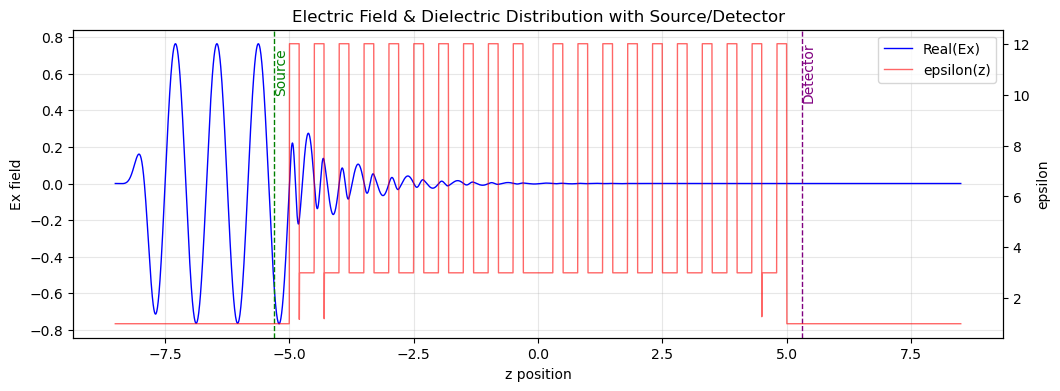

In [18]:
#電場分布
from matplotlib import pyplot as plt 
z_points = np.linspace(-sz/2, sz/2, int(resolution * sz))
ex_data = []
eps_data = []
for z in z_points:
    ex = sim_poyn.get_field_point(mp.Ex, mp.Vector3(z=z))
    eps = sim_poyn.get_epsilon_point(mp.Vector3(z=z))
    ex_data.append(ex)
    eps_data.append(eps)
ex_data = np.array(ex_data)
eps_data = np.array(eps_data)
#場分布+介電常數分布
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
#電場 Ex
ax1.plot(z_points, np.real(ex_data), 'b-', label='Real(Ex)', linewidth=1)
ax1.set_xlabel('z position')
ax1.set_ylabel('Ex field')
ax1.grid(True, alpha=0.3)
#介電常數
ax2 = ax1.twinx()
ax2.plot(z_points, eps_data, 'r-', label='epsilon(z)', linewidth=1, alpha=0.6)
ax2.set_ylabel('epsilon')
#Source 與 Detector 位置
ax1.axvline(sour_z, color='green', linestyle='--', linewidth=1)
ax1.text(sour_z, np.max(np.real(ex_data))*0.8, 'Source', color='green', 
         rotation=90, verticalalignment='center')
ax1.axvline(tran_z, color='purple', linestyle='--', linewidth=1)
ax1.text(tran_z, np.max(np.real(ex_data))*0.8, 'Detector', color='purple',
         rotation=90, verticalalignment='center')
#繪圖
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
ax1.set_title('Electric Field & Dielectric Distribution with Source/Detector')
plt.show()